### Install Dependencies

In [1]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128

Looking in indexes: https://download.pytorch.org/whl/cu128, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


### Import Dependencies

In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter
from models.POSTagger import POSTagger
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score



In [3]:
torch.cuda.get_device_name()

'NVIDIA GeForce GTX 1650'

### Load Data

In [4]:
# 1. Load Data
df_train = pd.read_json('datasets\\train.json', lines=True)
df_test = pd.read_json('datasets\\test.json', lines=True)

df_train.head()

,words,labels
0,"[Confidence, in, the, pound, is, widely, expec...","[NN, IN, DT, NN, VBZ, RB, VBN, TO, VB, DT, JJ,..."
1,"[Chancellor, of, the, Exchequer, Nigel, Lawson...","[NNP, IN, DT, NNP, NNP, NNP, POS, VBN, NN, TO,..."
2,"[But, analysts, reckon, underlying, support, f...","[CC, NNS, VBP, VBG, NN, IN, NN, VBZ, VBN, VBN,..."
3,"[This, has, increased, the, risk, of, the, gov...","[DT, VBZ, VBN, DT, NN, IN, DT, NN, VBG, VBN, T..."
4,"[``, The, risks, for, sterling, of, a, bad, tr...","[``, DT, NNS, IN, NN, IN, DT, JJ, NN, NN, VBP,..."


### Prep Data

In [ ]:
# 2. Build vocabularies
token_counter = Counter(token for row in df_train['words'] for token in row)
tag_counter = Counter(tag for row in df_train['labels'] for tag in row)

token2idx = {tok: i+2 for i, tok in enumerate(token_counter)}
token2idx['<PAD>'] = 0
token2idx['<UNK>'] = 1
idx2token = {i: t for t, i in token2idx.items()}

tag2idx = {tag: i for i, tag in enumerate(tag_counter)}
idx2tag = {i: t for t, i in tag2idx.items()}
tag2idx['<PAD>'] = len(tag2idx)
idx2tag[tag2idx['<PAD>']] = '<PAD>'

# 3. Encode data
def encode(tokens, tags, token2idx, tag2idx, max_len):
    ids = [token2idx.get(tok, token2idx['<UNK>']) for tok in tokens]
    tag_ids = [tag2idx[tag] for tag in tags]
    # Padding
    ids += [token2idx['<PAD>']] * (max_len - len(ids))
    tag_ids += [tag2idx['<PAD>']] * (max_len - len(tag_ids))
    return ids, tag_ids

max_len = max(max(len(row) for row in df_train['words']), max(len(row) for row in df_test['words']))

X_train = []
y_train = []
for _, row in df_train.iterrows():
    ids, tag_ids = encode(row['words'], row['labels'], token2idx, tag2idx, max_len)
    X_train.append(ids)
    y_train.append(tag_ids)
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)

batch_size = 16

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


X_test = []
y_test = []
for _, row in df_test.iterrows():
    ids, tag_ids = encode(row['words'], row['labels'], token2idx, tag2idx, max_len)
    X_test.append(ids)
    y_test.append(tag_ids)
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=4)  


In [6]:
# 4. Model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vocab_size = len(token2idx)
tagset_size = len(tag2idx)
embedding_dim = 32
hidden_dim = 32
num_layers = 1
dropout = 0.3

torch.cuda.empty_cache()

model = POSTagger(vocab_size, embedding_dim, hidden_dim, tagset_size, num_layers, dropout, token2idx).to(device)
loss_fn = nn.CrossEntropyLoss(ignore_index=tag2idx['<PAD>'])
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 5. Training loop
loss_history = []
for epoch in range(100):
    model.train()
    h = None  # Reset hidden state
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        logits = model(inputs)
        # h = h.detach()  # Critical for RNNs!
        loss = loss_fn(logits.view(-1, tagset_size), targets.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f"Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.4f}")
    loss_history.append(loss.item())
    torch.cuda.empty_cache()  # Clear GPU cache
    


Epoch 0, Batch 0, Loss: 3.9755
Epoch 0, Batch 100, Loss: 2.5621
Epoch 0, Batch 200, Loss: 2.1430
Epoch 0, Batch 300, Loss: 1.7778
Epoch 0, Batch 400, Loss: 1.6770
Epoch 0, Batch 500, Loss: 1.5056
Epoch 0, Batch 600, Loss: 1.2778
Epoch 0, Batch 700, Loss: 1.2923
Epoch 0, Batch 800, Loss: 1.2914
Epoch 1, Batch 0, Loss: 1.1161
Epoch 1, Batch 100, Loss: 1.1664
Epoch 1, Batch 200, Loss: 1.1660
Epoch 1, Batch 300, Loss: 1.0735
Epoch 1, Batch 400, Loss: 1.0518
Epoch 1, Batch 500, Loss: 0.8199
Epoch 1, Batch 600, Loss: 0.9769
Epoch 1, Batch 700, Loss: 0.9424
Epoch 1, Batch 800, Loss: 0.8528
Epoch 2, Batch 0, Loss: 0.8749
Epoch 2, Batch 100, Loss: 0.7853
Epoch 2, Batch 200, Loss: 0.8693
Epoch 2, Batch 300, Loss: 0.7619
Epoch 2, Batch 400, Loss: 0.6696
Epoch 2, Batch 500, Loss: 0.8105
Epoch 2, Batch 600, Loss: 0.5965
Epoch 2, Batch 700, Loss: 0.7637
Epoch 2, Batch 800, Loss: 0.7200
Epoch 3, Batch 0, Loss: 0.6131
Epoch 3, Batch 100, Loss: 0.7088
Epoch 3, Batch 200, Loss: 0.5627
Epoch 3, Batch 300

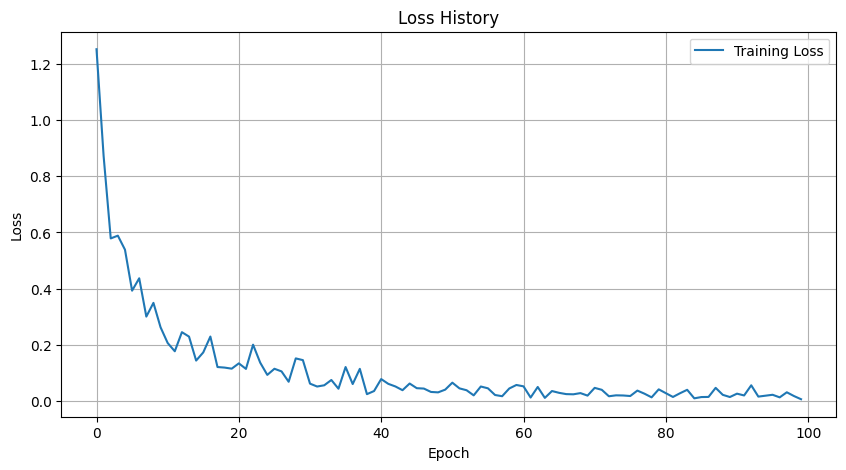

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Save 
torch.save({
    'model_state_dict': model.state_dict(),
    'token2idx': token2idx,  # Save vocab mappings
    'tag2idx': tag2idx       # Save tag mappings
}, 'models/POSTagger.pt')

In [7]:
device='cpu'
# Load
checkpoint = torch.load('models/POSTagger.pt', map_location=device)
model = POSTagger(
    vocab_size=len(checkpoint['token2idx']),
    embedding_dim=32,
    hidden_dim=32,
    tagset_size=len(checkpoint['tag2idx']),
    num_layers=1,
    dropout=0.3,
    token2idx=checkpoint['token2idx']
).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        logits = model(inputs)
        preds = logits.argmax(-1)
        mask = (inputs != token2idx['<PAD>'])
        
        # Flatten and filter out PAD tokens
        for i in range(preds.shape[0]):
            for j in range(preds.shape[1]):
                if mask[i, j]:
                    all_preds.append(preds[i, j].item())
                    all_targets.append(targets[i, j].item())


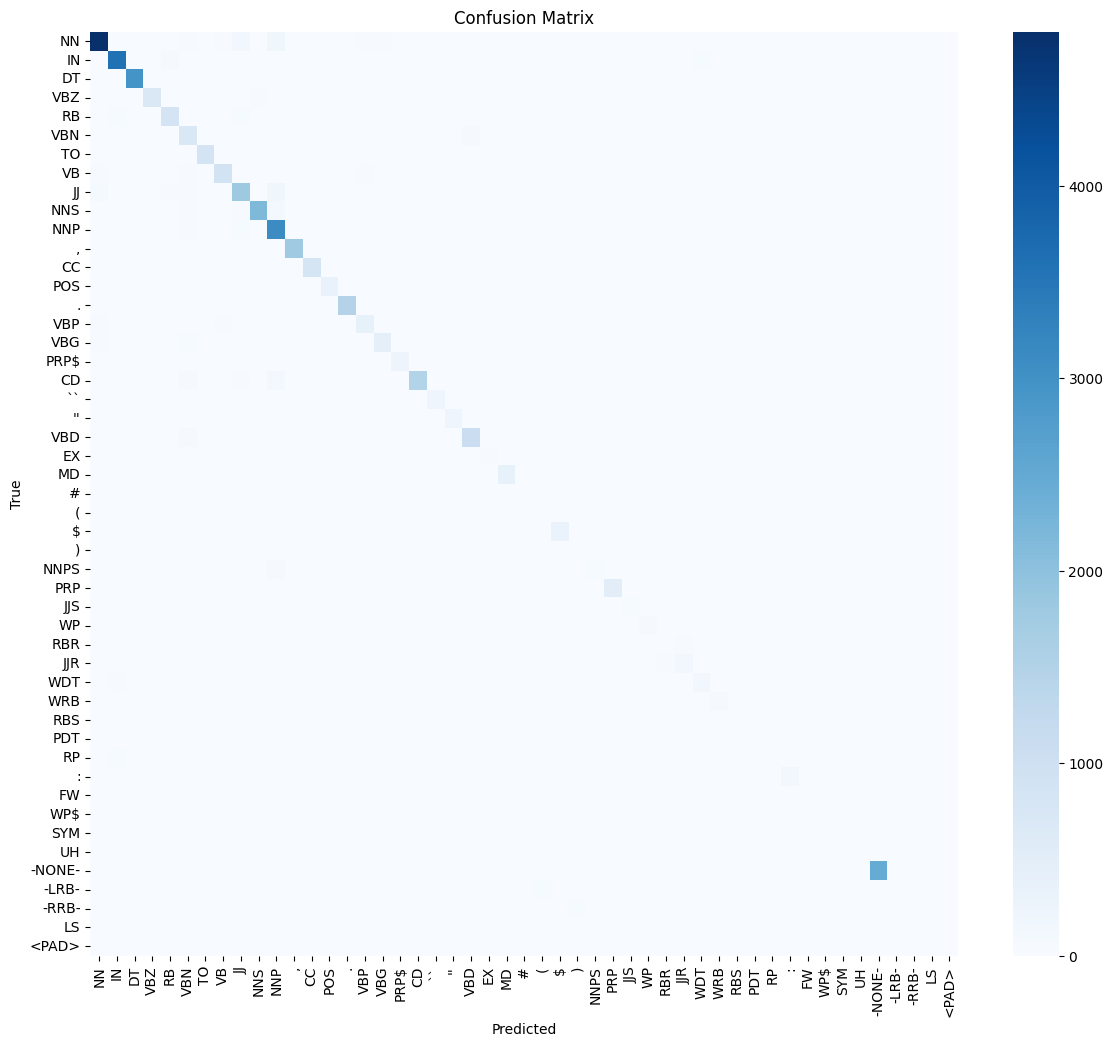

Accuracy:         0.9330
Macro Precision:  0.8035
Macro Recall:     0.7599
Macro F1-score:   0.7649
Weighted Precision: 0.9394
Weighted Recall:    0.9330
Weighted F1-score:  0.9337


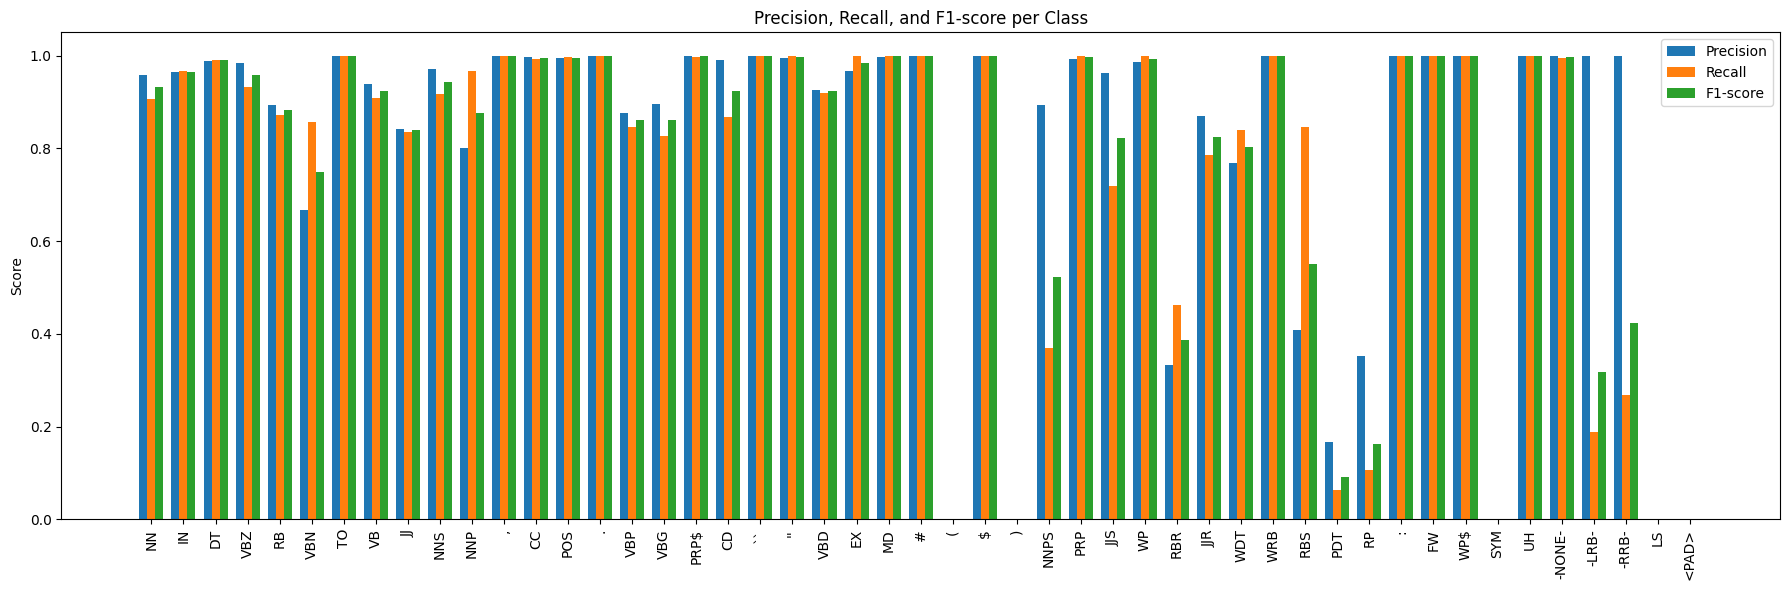

In [8]:
# 1. Confusion Matrix Heatmap
cm = confusion_matrix(all_targets, all_preds, labels=list(range(len(idx2tag))))
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=[idx2tag[i] for i in range(len(idx2tag))],
            yticklabels=[idx2tag[i] for i in range(len(idx2tag))])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 2. Bar Plot for Precision, Recall, F1-score
report = classification_report(
    all_targets, all_preds,
    labels=list(range(len(idx2tag))),
    target_names=[idx2tag[i] for i in range(len(idx2tag))],
    output_dict=True,
    zero_division=0
)

# Accuracy
accuracy = accuracy_score(all_targets, all_preds)

# Macro and weighted averages
macro_precision = report['macro avg']['precision']
macro_recall = report['macro avg']['recall']
macro_f1 = report['macro avg']['f1-score']

weighted_precision = report['weighted avg']['precision']
weighted_recall = report['weighted avg']['recall']
weighted_f1 = report['weighted avg']['f1-score']

print(f"Accuracy:         {accuracy:.4f}")
print(f"Macro Precision:  {macro_precision:.4f}")
print(f"Macro Recall:     {macro_recall:.4f}")
print(f"Macro F1-score:   {macro_f1:.4f}")
print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall:    {weighted_recall:.4f}")
print(f"Weighted F1-score:  {weighted_f1:.4f}")

# Remove 'accuracy', 'macro avg', 'weighted avg', 'micro avg'
report = {k: v for k, v in report.items() if k not in ['accuracy', 'macro avg', 'weighted avg', 'micro avg']}

labels = list(report.keys())
precision = [report[l]['precision'] for l in labels]
recall = [report[l]['recall'] for l in labels]
f1 = [report[l]['f1-score'] for l in labels]

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(18, 6))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1-score')
plt.xticks(x, labels, rotation=90)
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score per Class')
plt.legend()
plt.tight_layout()
plt.show()

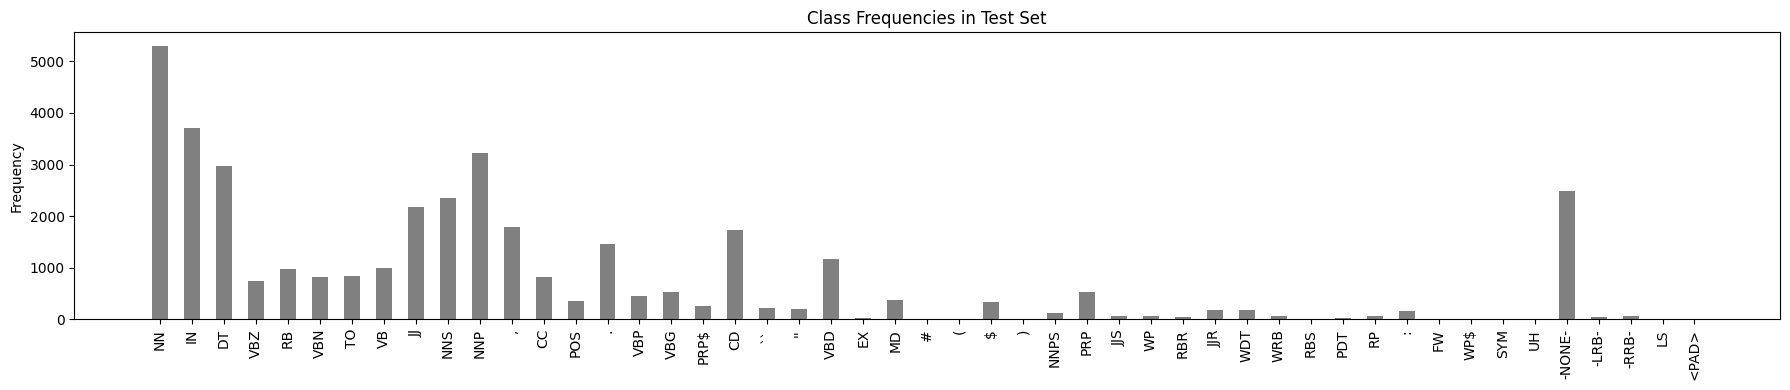

In [9]:
# Count frequencies for each class in the same order as 'labels'
freqs = [all_targets.count(tag2idx[l]) for l in labels]

plt.figure(figsize=(18, 4))
plt.bar(x, freqs, width=0.5, color='gray')
plt.xticks(x, labels, rotation=90)
plt.ylabel('Frequency')
plt.title('Class Frequencies in Test Set')
plt.tight_layout()
plt.show()

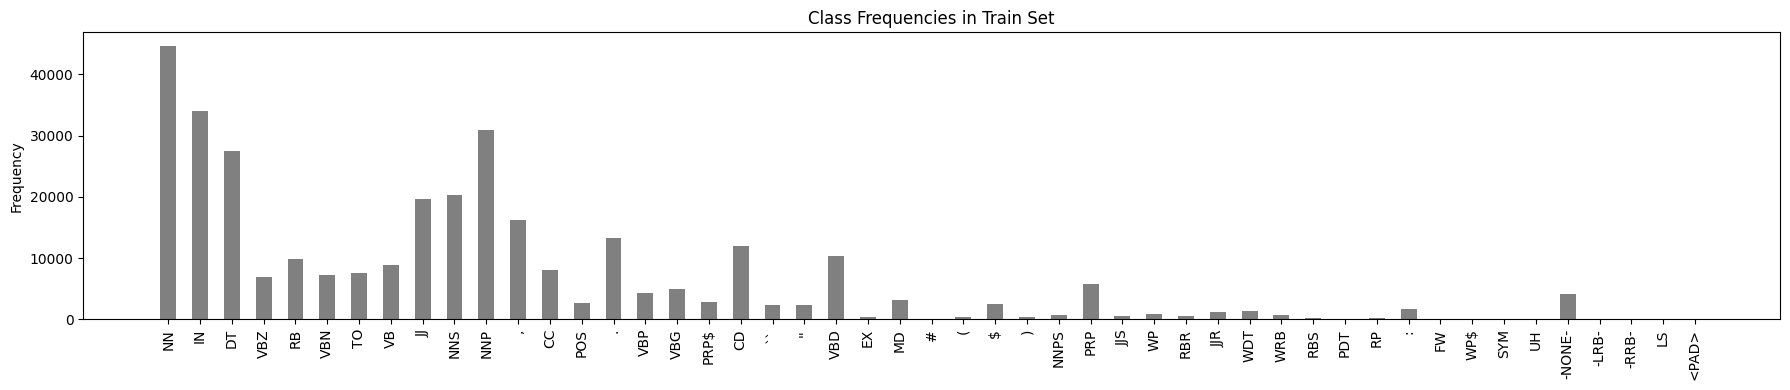

In [10]:
# Use tag_counter and labels to plot train set frequencies in the same order as metrics
train_freqs = [tag_counter.get(l, 0) for l in labels]

plt.figure(figsize=(18, 4))
plt.bar(x, train_freqs, width=0.5, color='gray')
plt.xticks(x, labels, rotation=90)
plt.ylabel('Frequency')
plt.title('Class Frequencies in Train Set')
plt.tight_layout()
plt.show()